In [ ]:
!pip install tensorflow==2.9.1 tensorflow_datasets==4.6.0

from __future__ import absolute_import, division, print_function, unicode_literals

import sys
import os
import re
import numpy as np
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

tf.keras.utils.set_random_seed(1234)

print(f"Tensorflow version {tf.__version__}")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU {}".format(tpu.cluster_spec().as_dict()["worker"]))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print(f"REPLICAS: {strategy.num_replicas_in_sync}")

REPLICAS: 1


In [4]:
# Maximum sentence length
MAX_LENGTH = 150

# Maximum number of samples to preprocess
MAX_SAMPLES = 50000

# For tf.data.Dataset
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
BUFFER_SIZE = 20000

# For Transformer
NUM_LAYERS = 2
D_MODEL = 128
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

EPOCHS = 40

In [ ]:
# path_to_zip = tf.keras.utils.get_file(
#     "cornell_movie_dialogs.zip",
#     origin="http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip",
#     extract=True,
# )

# path_to_dataset = os.path.join(
#     os.path.dirname(path_to_zip), "cornell movie-dialogs corpus"
# )

# path_to_movie_lines = os.path.join(path_to_dataset, "movie_lines.txt")
# path_to_movie_conversations = os.path.join(path_to_dataset, "movie_conversations.txt")

9916637/9916637 [==============================] - 2s 0us/step


In [5]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # removing contractions
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence


# def load_conversations():
#     # dictionary of line id to text
#     id2line = {}
#     with open(path_to_movie_lines, errors="ignore") as file:
#         lines = file.readlines()
#     for line in lines:
#         parts = line.replace("\n", "").split(" +++$+++ ")
#         id2line[parts[0]] = parts[4]

#     inputs, outputs = [], []
#     with open(path_to_movie_conversations, "r") as file:
#         lines = file.readlines()
#     for line in lines:
#         parts = line.replace("\n", "").split(" +++$+++ ")
#         # get conversation in a list of line ID
#         conversation = [line[1:-1] for line in parts[3][1:-1].split(", ")]
#         for i in range(len(conversation) - 1):
#             inputs.append(preprocess_sentence(id2line[conversation[i]]))
#             outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
#             if len(inputs) >= MAX_SAMPLES:
#                 return inputs, outputs
#     return inputs, outputs


# questions, answers = load_conversations()

In [6]:
import pandas as pd

conversations = pd.read_csv('/content/drive/MyDrive/dataset.csv', encoding="latin-1")

In [7]:
data = conversations[['customer_query','intent','sentiment','responses']]

In [8]:
data['customer_query'] = data['customer_query'].apply(preprocess_sentence)
data['responses'] = data['responses'].apply(preprocess_sentence)

<ipython-input-8-c821ea553b7c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['customer_query'] = data['customer_query'].apply(preprocess_sentence)
<ipython-input-8-c821ea553b7c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['responses'] = data['responses'].apply(preprocess_sentence)


In [9]:
data['customer_query'].shape

(6078,)

In [10]:
print(len(data['customer_query'].values))

6078


In [11]:
questions = data['customer_query'].values
answers = data['responses'].values

In [12]:
questions.shape

(6078,)

In [13]:
print(questions, answers)

['i want to return my order' 'can i get a refund for this product ?'
 'the product i received is damaged' ...
 'the new tv i purchased is incredible ! the display quality is stunning , and it offers a wide range of connectivity options .'
 'i am writing to express my appreciation for the refrigerator i recently bought . it is spacious , energy efficient , and keeps my food fresh and organized .'
 'i just wanted to let you know how happy i am with the washing machine i purchased . it is reliable , efficient , and has simplified my laundry routine .'] ['i am sorry to hear that . please provide your order number , and we will assist you with the return process .'
 'sure ! to process a refund , please provide your order number and reason for the refund .'
 'i apologize for the inconvenience caused . please provide your order number and details about the damage . we will assist you further .'
 ...
 'thank you for your feedback ! we are thrilled to know that the new tv you purchased is incre

In [14]:
print(questions.shape)

(6078,)


In [15]:
print(f"Sample question: {questions[20]}")
print(f"Sample answer: {answers[20]}")

Sample question: what is your return policy ?
Sample answer: our return policy allows you to return eligible items within days of purchase . please refer to our website for detailed information .


In [16]:
train_intents = data['intent'].values
train_sentiments = data['sentiment'].values

In [17]:
print(train_sentiments[50])

positive


In [18]:
from sklearn.preprocessing import LabelEncoder

intent_label_encoder = LabelEncoder()
intent_label_encoder.fit(train_intents)

sentiment_label_encoder = LabelEncoder()
sentiment_label_encoder.fit(train_sentiments)

LabelEncoder()

In [19]:
train_intent_labels = intent_label_encoder.transform(train_intents)
train_sentiment_labels = sentiment_label_encoder.transform(train_sentiments)

intents = train_intent_labels
sentiments = train_sentiment_labels

In [20]:
print(sentiments[50])

2


In [21]:
print(intents.shape)
print(sentiments.shape)

(6078,)
(6078,)


In [22]:
# Build tokenizer using tfds for both questions and answers
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13
)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [53]:
import pickle

# Save the tokenizer to a file using pickle
with open('/content/drive/MyDrive/tokenizer3.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
print(f"Tokenized sample question: {tokenizer.encode(questions[20])}")

Tokenized sample question: [97, 14, 12, 30, 1269, 23]


In [24]:
# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # tokenize sentence
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        # check tokenized sentence max length
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # pad tokenized sentences
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding="post"
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding="post"
    )

    return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questions, answers)

In [25]:
print(questions.shape)
print(answers.shape)

(6078, 150)
(6078, 150)


In [26]:
print(f"Vocab size: {VOCAB_SIZE}")
print(f"Number of samples: {len(questions)}")

Vocab size: 6583
Number of samples: 6078


In [27]:
print(answers)

[[6581    7   34 ...    0    0    0]
 [6581  577   37 ...    0    0    0]
 [6581    7   24 ...    0    0    0]
 ...
 [6581   62   10 ...    0    0    0]
 [6581    9  181 ...    0    0    0]
 [6581   62   10 ...    0    0    0]]


In [28]:
# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"inputs": questions, "intent_input":intents,"sentiment_input":sentiments, "dec_inputs": answers[:, :-1]},
        {"outputs": answers[:, 1:]},
    )
)

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [29]:
print(dataset)

<PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 150), dtype=tf.int32, name=None), 'intent_input': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'sentiment_input': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'dec_inputs': TensorSpec(shape=(None, 149), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 149), dtype=tf.int32, name=None)})>


In [30]:
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights."""
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += mask * -1e9

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

In [31]:
class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        assert d_model % num_heads == 0
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def get_config(self):
        config = super(MultiHeadAttentionLayer, self).get_config()
        config.update(
            {
                "num_heads": self.num_heads,
                "d_model": self.d_model,
            }
        )
        return config

    def split_heads(self, inputs, batch_size):
        inputs = tf.keras.layers.Lambda(
            lambda inputs: tf.reshape(
                inputs, shape=(batch_size, -1, self.num_heads, self.depth)
            )
        )(inputs)
        return tf.keras.layers.Lambda(
            lambda inputs: tf.transpose(inputs, perm=[0, 2, 1, 3])
        )(inputs)

    def call(self, inputs):
        query, key, value, mask = (
            inputs["query"],
            inputs["key"],
            inputs["value"],
            inputs["mask"],
        )
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        )(scaled_attention)

        # concatenation of heads
        concat_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.reshape(
                scaled_attention, (batch_size, -1, self.d_model)
            )
        )(scaled_attention)

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

In [32]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [33]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [34]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [35]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [36]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)
    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update(
            {
                "position": self.position,
                "d_model": self.d_model,
            }
        )
        return config
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    def positional_encoding(self, position, d_model)
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model,
        )
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)
    def call(self, inputs):
        return inputs + self.pos_encoding[:, : tf.shape(inputs)[1], :]

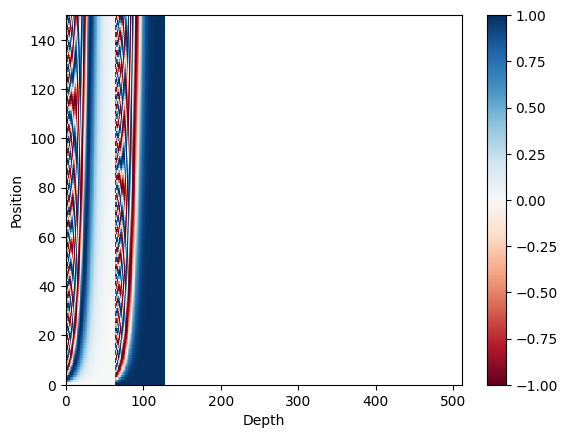

In [37]:
sample_pos_encoding = PositionalEncoding(150, 128, name="sample_pos_encoding")


plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap="RdBu")
plt.xlabel("Depth")
plt.xlim((0, 512))
plt.ylabel("Position")
plt.colorbar()
plt.show()

In [38]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    intent_input = tf.keras.Input(shape=(1,), name='intent_input')
    sentiment_input = tf.keras.Input(shape=(1,), name='sentiment_input')

    attention = MultiHeadAttentionLayer(d_model, num_heads, name="attention")(
        {"query": inputs, "key": inputs, "value": inputs, "mask": padding_mask}
    )

    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    add_attention = tf.keras.layers.add([inputs, attention])
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    # Reshape intent_input and sentiment_input to match attention's shape
    intent_input_reshaped = tf.expand_dims(intent_input, axis=1)
    sentiment_input_reshaped = tf.expand_dims(sentiment_input, axis=1)

    # Tile intent_input_reshaped and sentiment_input_reshaped to match attention's shape
    attention_shape = tf.shape(attention)
    multiples = [1, attention_shape[1], 1]
    intent_input_tiled = tf.tile(intent_input_reshaped, multiples)
    sentiment_input_tiled = tf.tile(sentiment_input_reshaped, multiples)

    # Concatenate with attention
    concat_input = tf.keras.layers.concatenate([attention, intent_input_tiled, sentiment_input_tiled], axis=-1)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(concat_input)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([attention, outputs])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(inputs=[inputs, padding_mask, intent_input, sentiment_input], outputs=outputs, name=name)

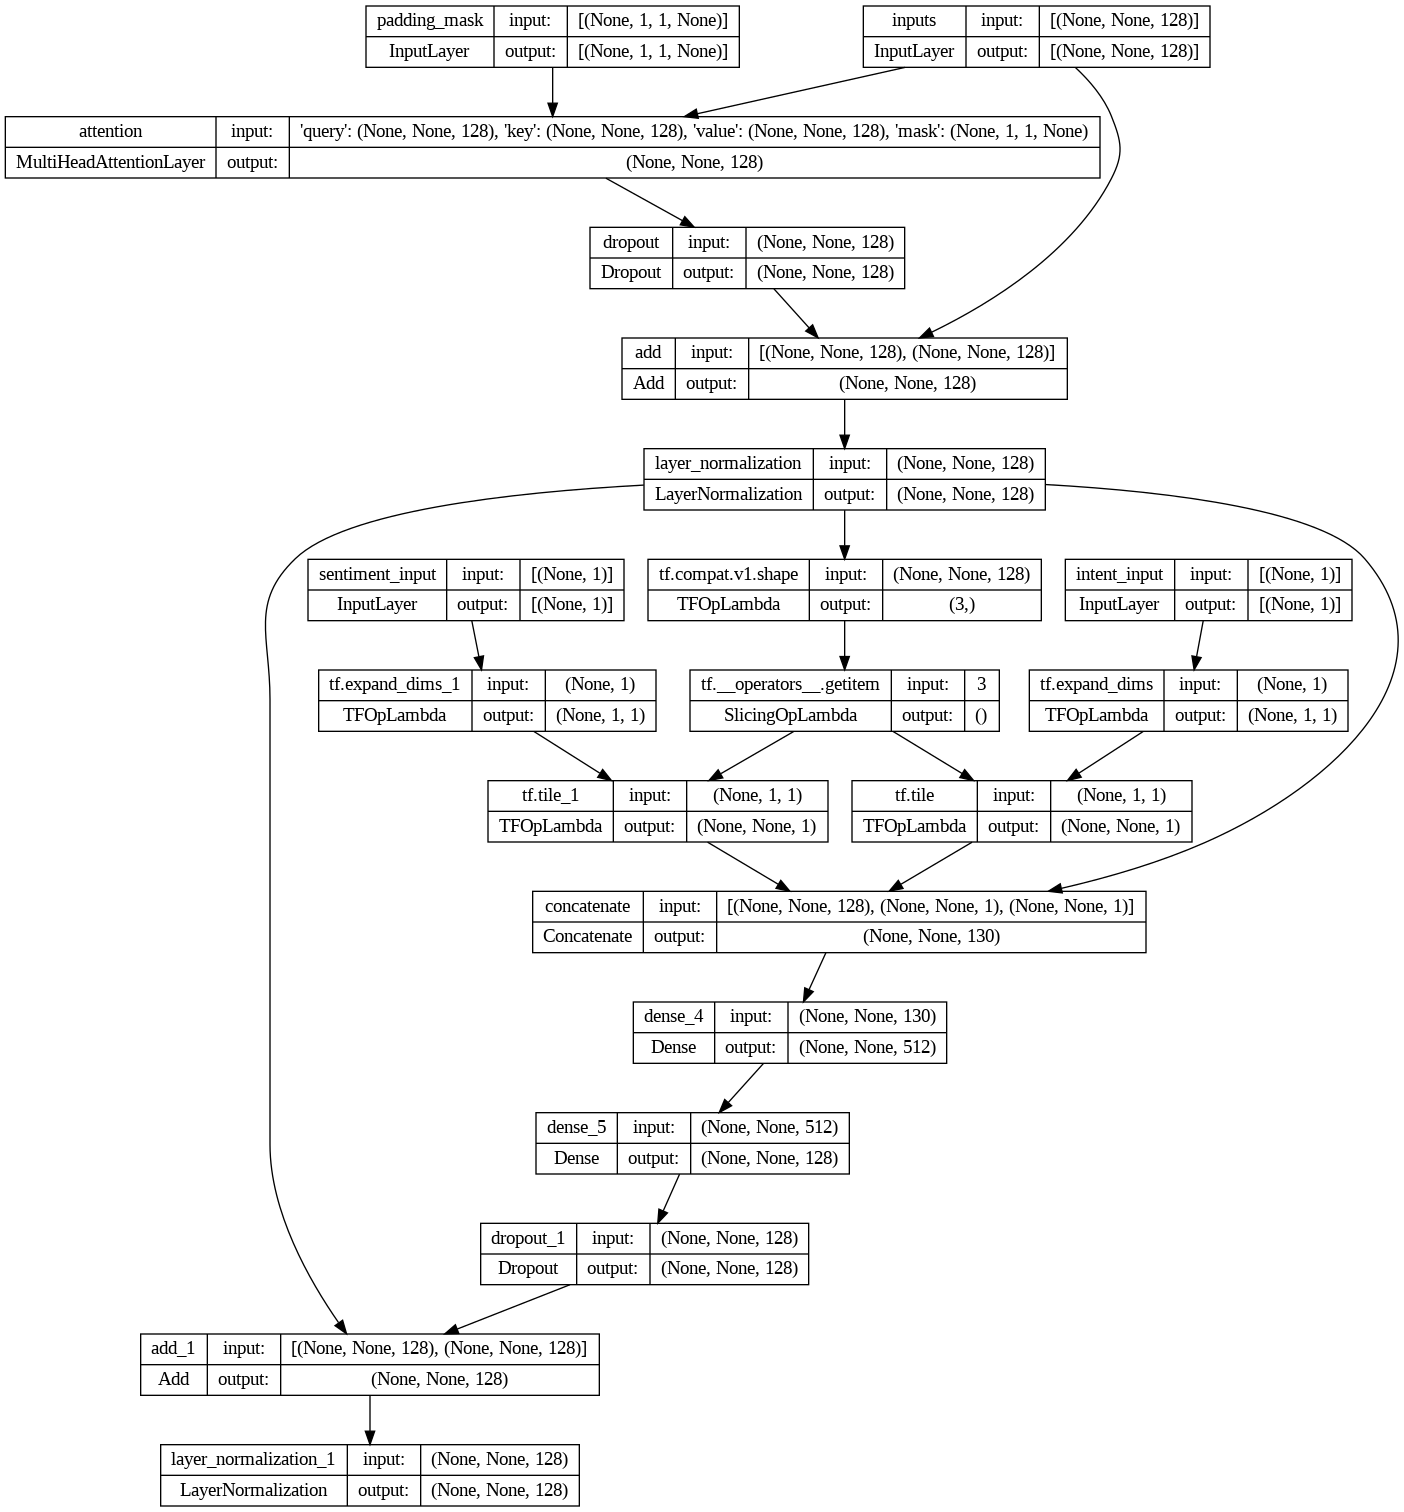

In [39]:
sample_encoder_layer = encoder_layer(
    units=512, d_model=128, num_heads=4, dropout=0.3, name="sample_encoder_layer"
)

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file="encoder_layer.png", show_shapes=True
)

In [40]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    intent_input = tf.keras.Input(shape=(1,), name='intent_input')
    sentiment_input = tf.keras.Input(shape=(1,), name='sentiment_input')

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)

    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)

    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # Define an empty list to store the outputs of each encoder layer
    encoder_layers_outputs = []

    # Recursive loop through the encoder layers
    for i in range(num_layers):
        # Get the output of the encoder layer
        encoder_layer_output = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask, intent_input, sentiment_input])

        # Append the output to the list
        encoder_layers_outputs.append(encoder_layer_output)

        # Pass the output of the encoder layer to the next iteration
        outputs = encoder_layer_output

    # Concatenate the outputs of all encoder layers
    outputs = tf.keras.layers.concatenate(encoder_layers_outputs, axis=-1)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask, intent_input, sentiment_input], outputs=outputs, name=name)

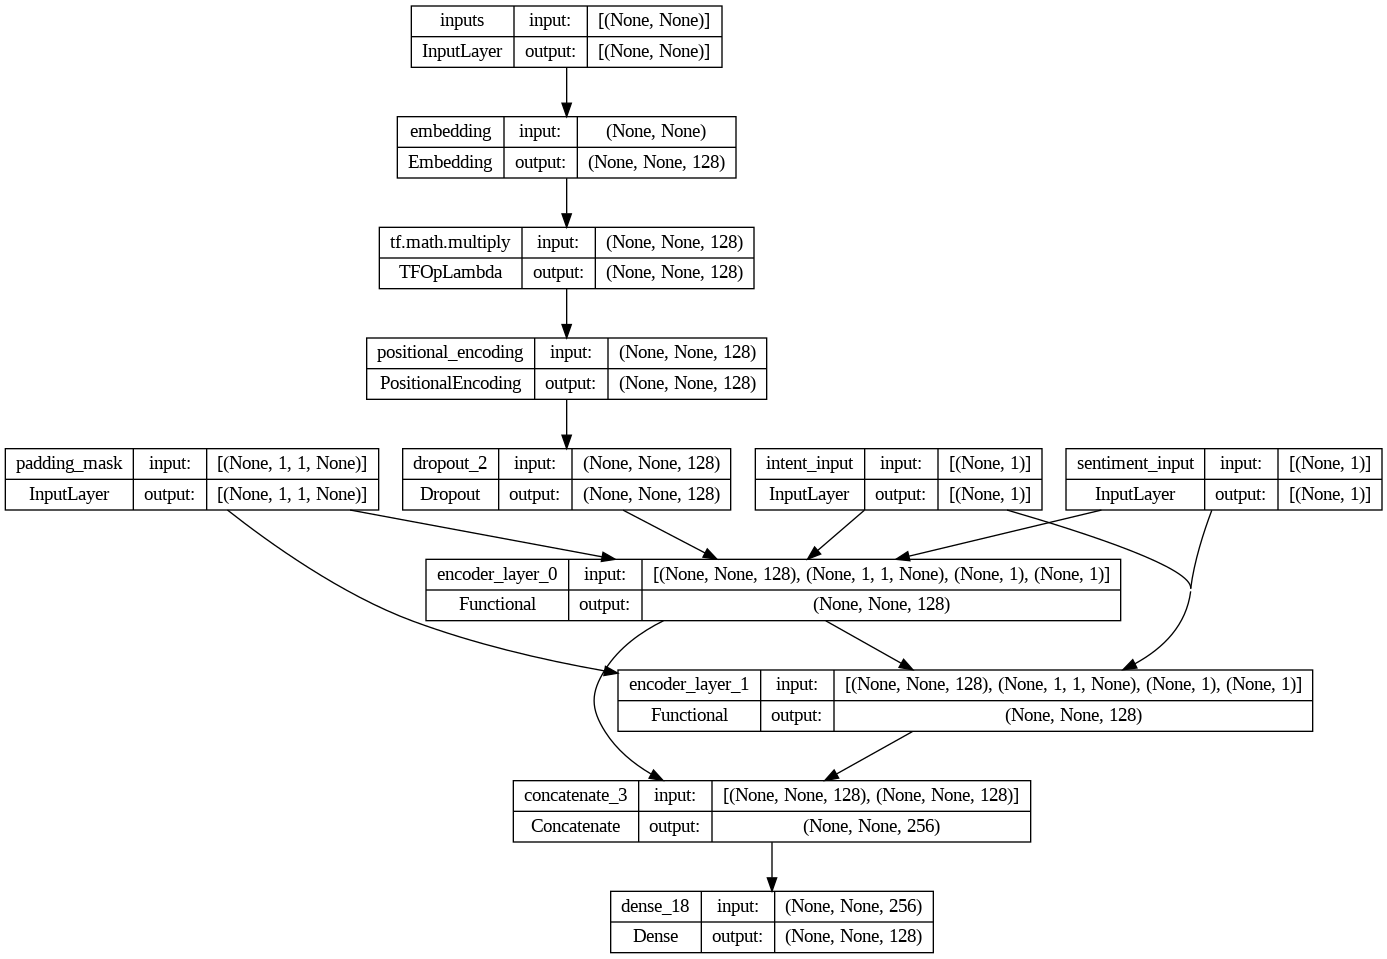

In [41]:
sample_encoder = encoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder",
)

tf.keras.utils.plot_model(sample_encoder, to_file="encoder.png", show_shapes=True)

In [42]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention1 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_1")(
        inputs={
            "query": inputs,
            "key": inputs,
            "value": inputs,
            "mask": look_ahead_mask,
        }
    )
    add_attention = tf.keras.layers.add([attention1, inputs])
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    attention2 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_2")(
        inputs={
            "query": attention1,
            "key": enc_outputs,
            "value": enc_outputs,
            "mask": padding_mask,
        }
    )
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    add_attention = tf.keras.layers.add([attention2, attention1])
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([outputs, attention2])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

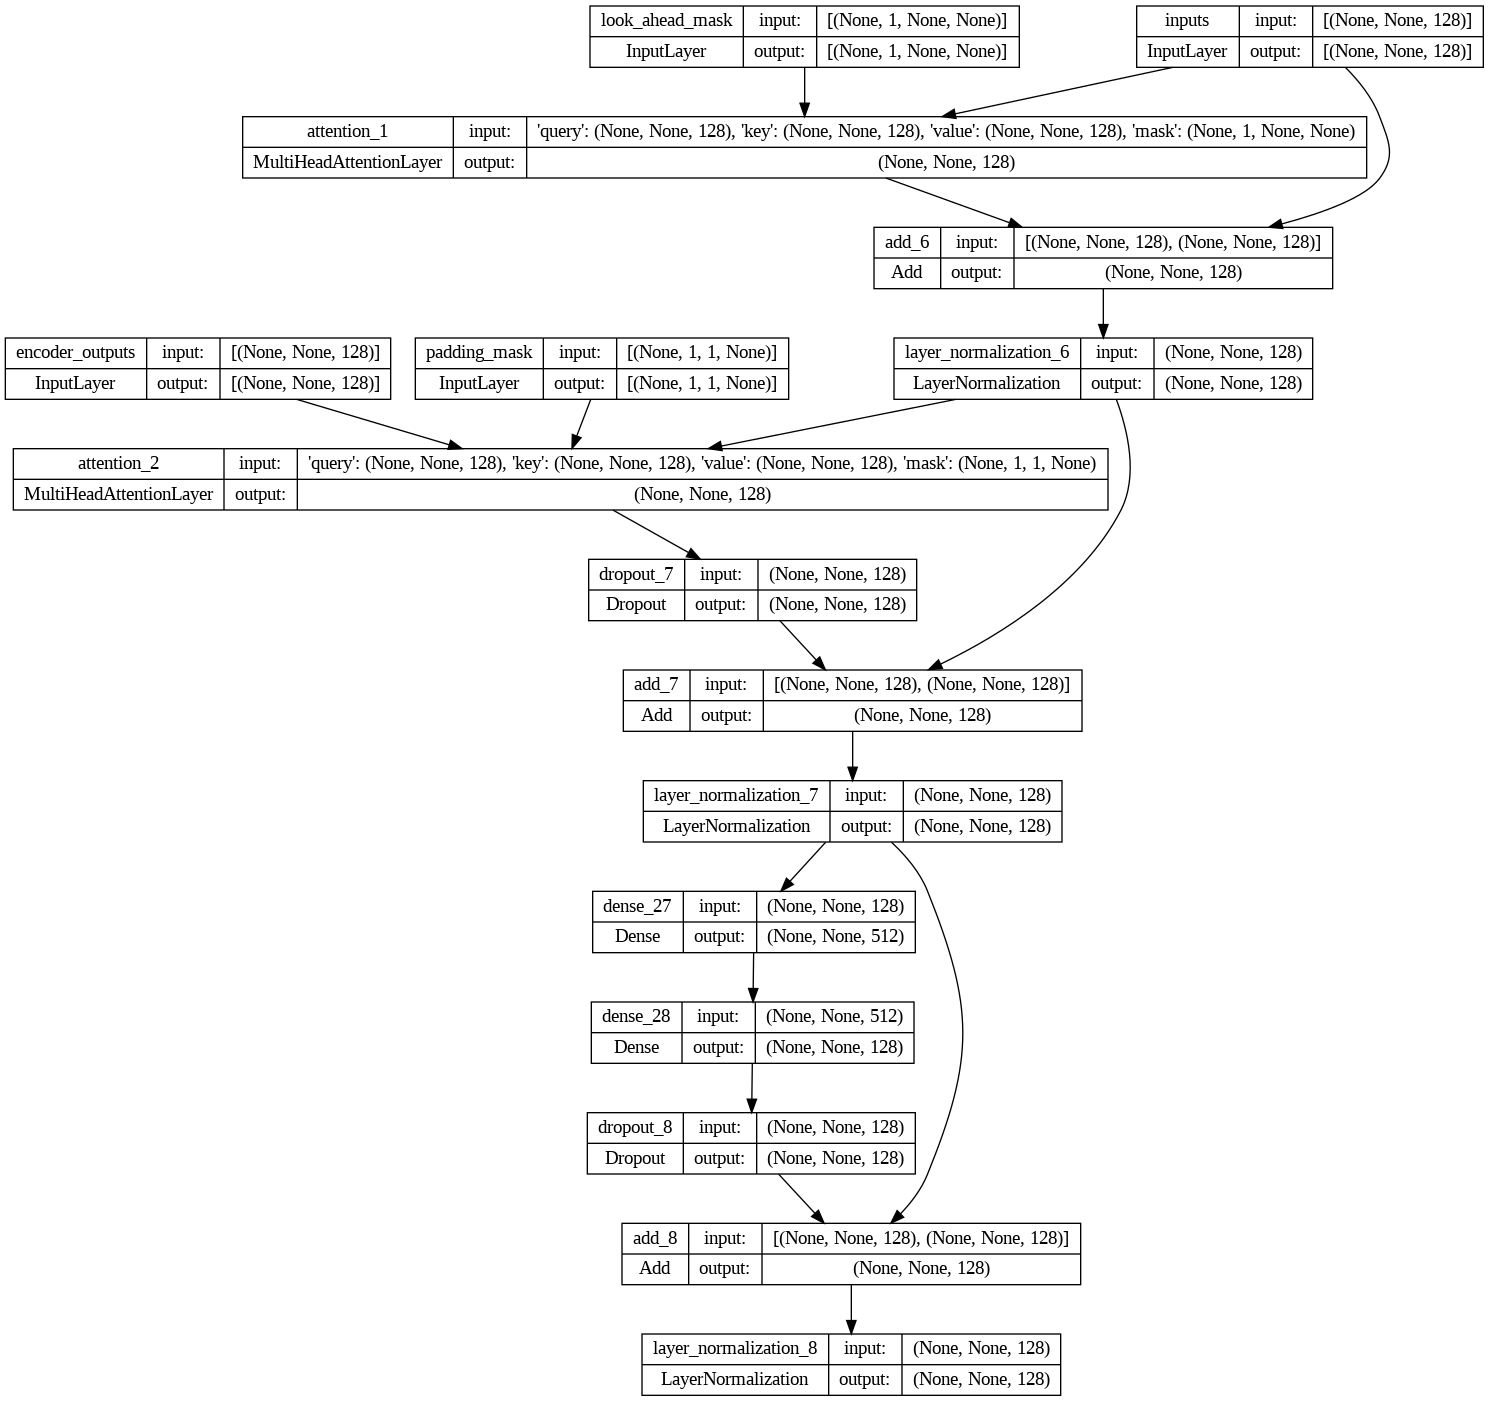

In [43]:
sample_decoder_layer = decoder_layer(
    units=512, d_model=128, num_heads=4, dropout=0.3, name="sample_decoder_layer"
)

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file="decoder_layer.png", show_shapes=True
)

In [44]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="decoder_layer_{}".format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

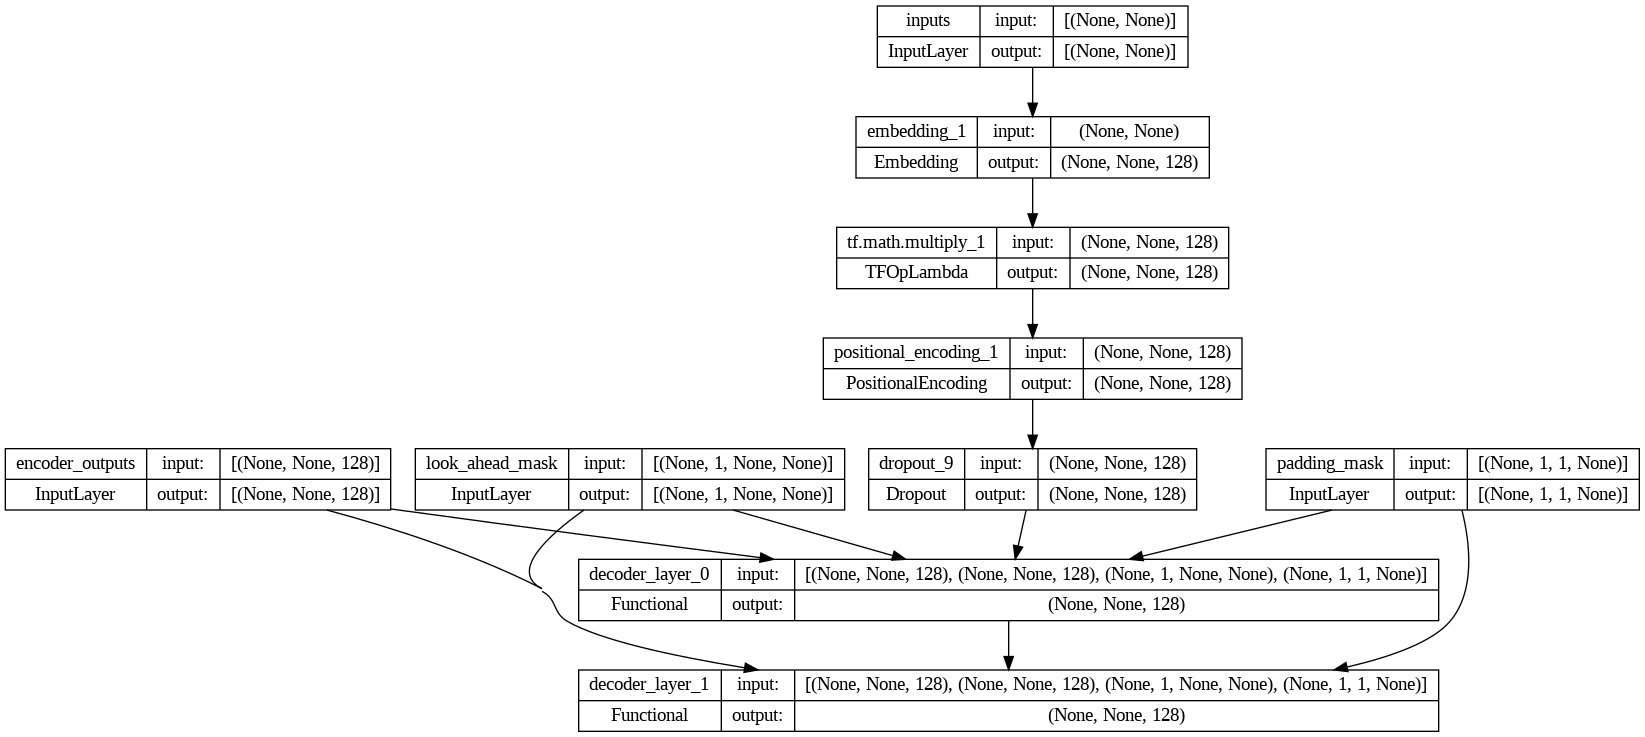

In [45]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder",
)

tf.keras.utils.plot_model(sample_decoder, to_file="decoder.png", show_shapes=True)

In [46]:
def transformer(
    vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"
):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")
    intent_input = tf.keras.Input(shape=(1,), name='intent_input')
    sentiment_input = tf.keras.Input(shape=(1,), name='sentiment_input')
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="enc_padding_mask"
    )(inputs)
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None), name="look_ahead_mask"
    )(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="dec_padding_mask"
    )(inputs)
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask, intent_input, sentiment_input])
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
    return tf.keras.Model(inputs=[inputs, dec_inputs, intent_input, sentiment_input], outputs=outputs, name=name)

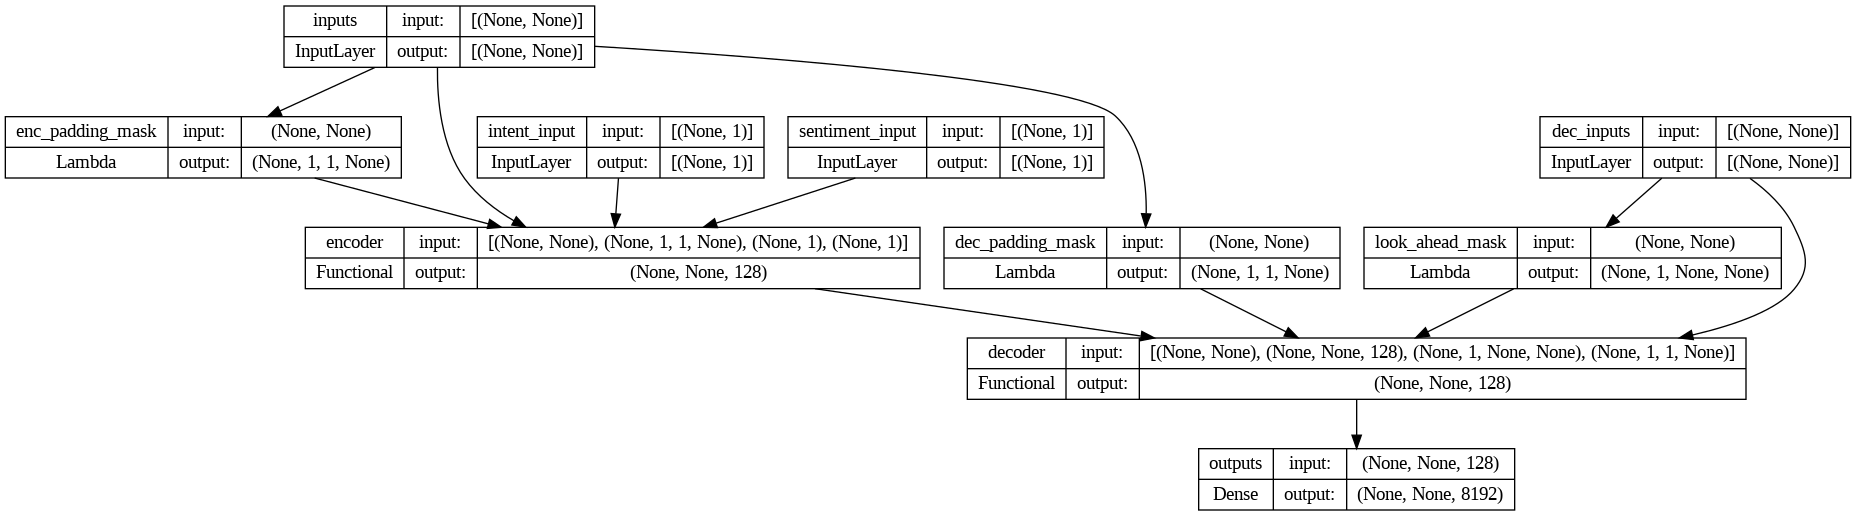

In [47]:
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=128,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer",
)

tf.keras.utils.plot_model(
    sample_transformer, to_file="transformer.png", show_shapes=True
)

In [48]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [49]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.constant(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps

    def get_config(self):
        return {"d_model": self.d_model, "warmup_steps": self.warmup_steps}

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.multiply(
            tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2)
        )

Text(0.5, 0, 'Train Step')

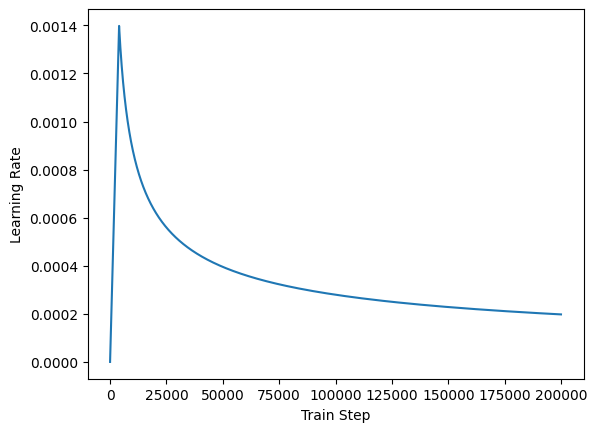

In [50]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [51]:
# clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)


def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


# initialize and compile model within strategy scope
with strategy.scope():
    model = transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT,
    )

    model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 intent_input (InputLayer)      [(None, 1)]          0           []                               
                                                                                        

In [52]:
model.fit(dataset, epochs=EPOCHS)

Epoch 1/40
95/95 [==============================] - 24s 129ms/step - loss: 2.1164 - accuracy: 0.0027
Epoch 2/40
95/95 [==============================] - 12s 129ms/step - loss: 1.9595 - accuracy: 0.0114
Epoch 3/40
95/95 [==============================] - 13s 133ms/step - loss: 1.7172 - accuracy: 0.0174
Epoch 4/40
95/95 [==============================] - 12s 129ms/step - loss: 1.4532 - accuracy: 0.0411
Epoch 5/40
95/95 [==============================] - 12s 130ms/step - loss: 1.2465 - accuracy: 0.0801
Epoch 6/40
95/95 [==============================] - 13s 133ms/step - loss: 1.0331 - accuracy: 0.1008
Epoch 7/40
95/95 [==============================] - 12s 129ms/step - loss: 0.8406 - accuracy: 0.1124
Epoch 8/40
95/95 [==============================] - 12s 130ms/step - loss: 0.7070 - accuracy: 0.1245
Epoch 9/40
95/95 [==============================] - 12s 128ms/step - loss: 0.6110 - accuracy: 0.1372
Epoch 10/40
95/95 [==============================] - 12s 131ms/step - loss: 0.5346 - accura

In [54]:
filename = "model.h5"
tf.keras.models.save_model(model, filepath=filename, include_optimizer=False)

In [55]:
del model
tf.keras.backend.clear_session()

In [56]:
model = tf.keras.models.load_model(
    filename,
    custom_objects={
        "PositionalEncoding": PositionalEncoding,
        "MultiHeadAttentionLayer": MultiHeadAttentionLayer,
    },
    compile=False,
)

In [57]:
def evaluate(sentence, intent_input, sentiment_input):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0
    )

    output = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output, intent_input, sentiment_input], training=False)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # concatenated the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)


def predict(sentence, intent_input, sentiment_input):
    prediction = evaluate(sentence, intent_input, sentiment_input)
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size]
    )
    return predicted_sentence

In [59]:
intent_input = np.array([[2]])
sentiment_input = np.array([[0]])

print(predict("I am sad.",intent_input,sentiment_input))

we apologize for the difficulties you are facing in tracking system . please provide us with more details about the problem , and we will assist you in resolving the problem .


In [ ]:
# print("Customer Query: ", "I am sad about my new purchase")
# print("Predicted: ", predict("I am sad about my new purchase"))
# print("Ground Truth : ","Thank you for your feedback! We're glad to hear that you're satisfied with your purchase.")

Customer Query:  I am sad about my new purchase
Predicted:  we are delighted to hear that you are satisfied with the desktop computer . your feedback is valuable , and we will work on resolving this problem to provide a better user experience .
Ground Truth :  Thank you for your feedback! We're glad to hear that you're satisfied with your purchase.
